## Introduction

This is an example notebook showing how to train and test a Variational AutoEncoder (VAE).
It closely follows Keras VAE example at https://keras.io/examples/generative/vae

## Setting up

In [1]:
!pip3 install -q git+https://github.com/NTT123/pax.git@dev_0.2.2#egg=pax[test]

In [2]:
from typing import NamedTuple

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import pax
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.auto import tqdm

pax.seed_rng_key(42)


### config ###
batch_size = 128
vae_dim = 2
learning_rate = 1e-3


class LossInfo(NamedTuple):
    # A record of training losses.
    loss: jnp.ndarray
    reconstruction_loss: jnp.ndarray
    kl_loss: jnp.ndarray

## Convolutional VAE model

In [3]:
class VariationalAutoEncoder(pax.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = pax.nn.Sequential(
            pax.nn.Conv2D(1, 32, 3, (2, 2), padding="SAME"),
            jax.nn.relu,
            pax.nn.Conv2D(32, 64, 3, (2, 2), padding="SAME"),
            jax.nn.relu,
            pax.utils.Lambda(lambda x: jnp.reshape(x, (x.shape[0], -1))),
            pax.nn.Linear(3136, 16),
            jax.nn.relu,
            pax.nn.Linear(16, 2 * latent_dim),
        )

        self.decoder = pax.nn.Sequential(
            pax.nn.Linear(latent_dim, 7 * 7 * 32),
            jax.nn.relu,
            lambda x: jnp.reshape(x, (x.shape[0], 7, 7, 32)),
            pax.haiku.conv_2d_transpose(32, 64, 3, 2, padding="SAME"),
            jax.nn.relu,
            pax.haiku.conv_2d_transpose(64, 32, 3, 2, padding="SAME"),
            jax.nn.relu,
            pax.haiku.conv_2d_transpose(32, 1, 3, 1, padding="SAME"),
        )
        # register an internal random key.
        self.register_state("rng_key", pax.next_rng_key())

    def __call__(self, x):
        x = self.encoder(x)
        vae_mean, vae_logvar = jnp.split(x, 2, axis=-1)
        if self.training:
            # refresh the internal random key.
            self.rng_key, rng_key = jax.random.split(self.rng_key)
        else:
            rng_key = self.rng_key
        noise = jax.random.normal(rng_key, shape=vae_mean.shape, dtype=vae_mean.dtype)
        x = noise * jnp.exp(0.5 * vae_logvar) + vae_mean
        x = self.decoder(x)
        return x, vae_mean, vae_logvar

## Loss function

The loss function is the sum of the ``recontruction_loss`` and the ``kl-divergence`` loss.

In [4]:
def loss_fn(
    params: VariationalAutoEncoder, model: VariationalAutoEncoder, inputs
) -> pax.utils.LossFnOutput:
    model = model.update(params)
    output, vae_mean, vae_logvar = model(inputs)
    N = inputs.shape[0]  # batch size
    reconstruction_loss = jnp.sum(optax.sigmoid_binary_cross_entropy(output, inputs))
    reconstruction_loss = reconstruction_loss / N
    kl_loss = jnp.sum(-0.5 * (1 + vae_logvar - jnp.square(vae_mean) - jnp.exp(vae_logvar)))
    kl_loss = kl_loss / N
    loss = reconstruction_loss + kl_loss
    return loss, (LossInfo(loss, reconstruction_loss, kl_loss), model)


## Tensorflow Dataloader

In [5]:
def load_dataset(with_label=False):
    """Return a tensorflow dataset.

    Arguments:
        with_label: bool, return (data, labels).

    """
    ds = tfds.load("mnist:3.*.*")
    ds = ds["train"].concatenate(ds["test"])
    ds = (
        ds
        .map(lambda x: (tf.cast(x["image"], tf.float32) / 255.0, x['label']))
        .map((lambda x, y: (x, y)) if with_label else (lambda x_, y_: x_))
        .cache()
        .shuffle(len(ds))  # shuffle the whole dataset
    )

    return ds

## Train model

===== VAE MODEL =====
VariationalAutoEncoder
├── Sequential
│   ├── Conv2D[in_features=1, out_features=32, with_bias=True]
│   ├── x => relu(x)
│   ├── Conv2D[in_features=32, out_features=64, with_bias=True]
│   ├── x => relu(x)
│   ├── x => <function VariationalAutoEncoder.__init__.<locals>.<lambda> at 0x7fa54052d320>(x)
│   ├── Linear[in_dim=3136, out_dim=16, with_bias=True]
│   ├── x => relu(x)
│   └── Linear[in_dim=16, out_dim=4, with_bias=True]
└── Sequential
    ├── Linear[in_dim=2, out_dim=1568, with_bias=True]
    ├── x => relu(x)
    ├── x => <function VariationalAutoEncoder.__init__.<locals>.<lambda> at 0x7fa5404f5c20>(x)
    ├── Conv2DTranspose@haiku[output_channels=64, kernel_shape=3, stride=2, output_shape=None, padding=SAME, with_bias=True, w_init=None, b_init=None, data_format=NHWC, mask=None]
    ├── x => relu(x)
    ├── Conv2DTranspose@haiku[output_channels=32, kernel_shape=3, stride=2, output_shape=None, padding=SAME, with_bias=True, w_init=None, b_init=None, data_for

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  0]  train loss 208.315  reconstruction loss 203.834  kl_loss 4.481


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  1]  train loss 169.208  reconstruction loss 163.915  kl_loss 5.294


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  2]  train loss 163.396  reconstruction loss 157.788  kl_loss 5.607


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  3]  train loss 160.145  reconstruction loss 154.349  kl_loss 5.796


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  4]  train loss 158.199  reconstruction loss 152.284  kl_loss 5.915


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  5]  train loss 156.713  reconstruction loss 150.719  kl_loss 5.994


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  6]  train loss 155.748  reconstruction loss 149.693  kl_loss 6.056


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  7]  train loss 154.978  reconstruction loss 148.881  kl_loss 6.097


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  8]  train loss 154.231  reconstruction loss 148.110  kl_loss 6.121


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch  9]  train loss 153.666  reconstruction loss 147.500  kl_loss 6.166


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 10]  train loss 153.188  reconstruction loss 147.003  kl_loss 6.185


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 11]  train loss 152.736  reconstruction loss 146.526  kl_loss 6.210


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 12]  train loss 152.431  reconstruction loss 146.190  kl_loss 6.242


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 13]  train loss 152.009  reconstruction loss 145.759  kl_loss 6.250


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 14]  train loss 151.763  reconstruction loss 145.521  kl_loss 6.242


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 15]  train loss 151.448  reconstruction loss 145.173  kl_loss 6.276


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 16]  train loss 151.227  reconstruction loss 144.933  kl_loss 6.295


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 17]  train loss 151.030  reconstruction loss 144.714  kl_loss 6.316


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 18]  train loss 150.728  reconstruction loss 144.424  kl_loss 6.304


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 19]  train loss 150.550  reconstruction loss 144.231  kl_loss 6.319


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 20]  train loss 150.329  reconstruction loss 143.988  kl_loss 6.341


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 21]  train loss 150.340  reconstruction loss 143.989  kl_loss 6.351


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 22]  train loss 150.056  reconstruction loss 143.678  kl_loss 6.378


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 23]  train loss 149.893  reconstruction loss 143.502  kl_loss 6.391


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 24]  train loss 149.650  reconstruction loss 143.280  kl_loss 6.369


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 25]  train loss 149.616  reconstruction loss 143.233  kl_loss 6.382


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 26]  train loss 149.407  reconstruction loss 143.026  kl_loss 6.382


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 27]  train loss 149.290  reconstruction loss 142.884  kl_loss 6.407


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 28]  train loss 149.171  reconstruction loss 142.752  kl_loss 6.419


train:   0%|          | 0/546 [00:00<?, ?it/s]

[Epoch 29]  train loss 149.047  reconstruction loss 142.620  kl_loss 6.427


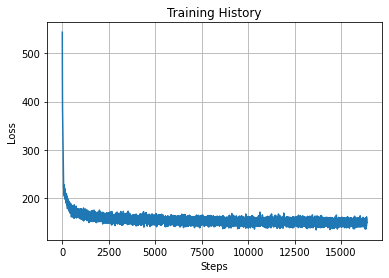

In [6]:
def train():
    vae = VariationalAutoEncoder(vae_dim)
    print(f"===== VAE MODEL =====\n{vae.summary()}\n\n")
    optimizer = pax.optim.from_optax(optax.adam(learning_rate, eps=1e-7))(vae.parameters())

    train_data = load_dataset(with_label=False).batch(batch_size, drop_remainder=True)
    fast_update_fn = jax.jit(pax.utils.build_update_fn(loss_fn))

    training_losses = []
    for epoch in tqdm(range(30), desc="Epoch", leave=False):
        losses = LossInfo(0.0, 0.0, 0.0)
        for batch in tqdm(train_data, desc="train", leave=False):
            batch = jax.tree_map(lambda x: x.numpy(), batch)
            loss_info, vae, optimizer = fast_update_fn(vae, optimizer, batch)
            training_losses.append(loss_info.loss)
            losses = jax.tree_map(lambda x, y: x + y, losses, loss_info)

        losses = jax.tree_map(lambda x: x / len(train_data), losses)
        print(
            f"[Epoch {epoch:>2}]  train loss {losses.loss:.3f}  reconstruction loss {losses.reconstruction_loss:.3f}  kl_loss {losses.kl_loss:.3f}"
        )

    plt.plot(training_losses)
    plt.grid("on")
    plt.ylabel("Loss")
    plt.xlabel("Steps")
    plt.title('Training History')
    plt.show()
    return vae


vae = train()

## Evaluation

We inspect the latent space learned by our VAE model.

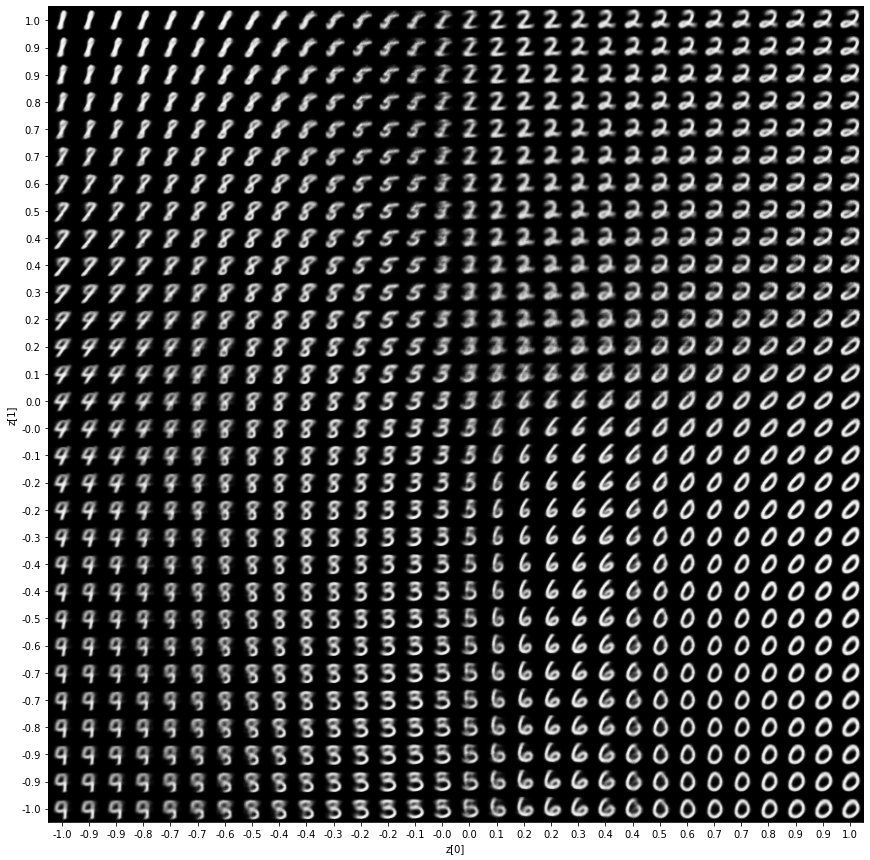

In [7]:
# Source: https://keras.io/examples/generative/vae
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    fast_decoder = jax.jit(lambda model, z: model.decoder(z))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = jax.nn.sigmoid(fast_decoder(vae, z_sample))
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae.eval())

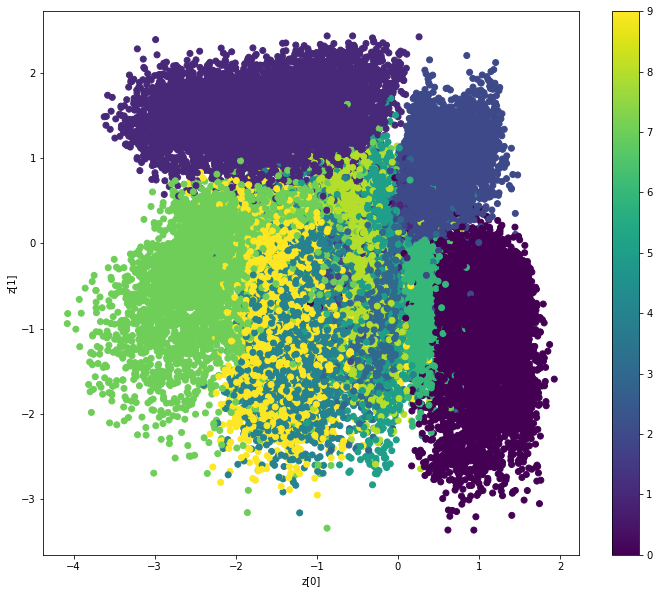

In [8]:
# Source: https://keras.io/examples/generative/vae
def plot_label_clusters(vae, data):
    # display a 2D plot of the digit classes in the latent space

    all_z_means = []
    all_labels = []

    fast_encoder = jax.jit(lambda model, data: model.encoder(data))
    
    for batch in data:
        batch = jax.tree_map(lambda x: x.numpy(), batch)
        data, label = batch
        z = fast_encoder(vae, data)
        z_mean, _ = jnp.split(z, 2, axis=-1)
        all_z_means.append(z_mean)
        all_labels.append(label)
    
    all_z_means = jnp.concatenate(all_z_means)
    all_labels = jnp.concatenate(all_labels)
    plt.figure(figsize=(12, 10))
    plt.scatter(all_z_means[:, 0], all_z_means[:, 1], c=all_labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


data = load_dataset(with_label=True).batch(batch_size, drop_remainder=True)
plot_label_clusters(vae.eval(), data)